<a href="https://colab.research.google.com/github/rajdeepbasu/Transformers/blob/main/FineTuning_MultiClass_Classification_using_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install sentencepiece
!pip install silence-tensorflow
!pip install beautifulsoup4
! pip install -q kaggle

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-_aq2ve7r
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-_aq2ve7r
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2170971 sha256=bdff018f1547ba34a3e3aa553d277cc6f15dd59a10153512d65dd21ff9b72dcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-_hav7j4x/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers


In [ ]:
 from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"rajdeepbasu","key":"69076ec28d15840538373573faaf191f"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Listing kaggle datasets
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-05-03 13:54:12           4183  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2401  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            541  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            251  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [ ]:
# Downloading kaggle dataset
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification

bbc-full-text-document-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! mkdir train
! unzip /content/bbc-full-text-document-classification.zip -d train

mkdir: cannot create directory ‘train’: File exists
Archive:  /content/bbc-full-text-document-classification.zip
replace train/bbc-fulltext (document classification)/bbc/README.TXT? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace train/bbc-fulltext (document classification)/bbc/README.TXT? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/bbc-fulltext (document classification)/bbc/README.TXT  
  inflating: train/bbc-fulltext (document classification)/bbc/business/001.txt  
  inflating: train/bbc-fulltext (document classification)/bbc/business/002.txt  
  inflating: train/bbc-fulltext (document classification)/bbc/business/003.txt  
  inflating: train/bbc-fulltext (document classification)/bbc/business/004.txt  
  inflating: train/bbc-fulltext (document classification)/bbc/business/005.txt  
  inflating: train/bbc-fulltext (document classification)/bbc/business/006.txt  
  inflating: train/bbc-fulltext (document classification)/bbc/business/007.txt 

In [ ]:
# Importing huggingface transformers package
from transformers import DistilBertTokenizerFast, LongformerTokenizerFast, BigBirdTokenizer
from transformers import TFDistilBertForSequenceClassification, TFLongformerForSequenceClassification, BigBirdForSequenceClassification
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# Importing tensorflow
import tensorflow as tf

# Importing NLTK & other necessary nltk packages
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Importing sklearn packages
from sklearn.model_selection import train_test_spl
from sklearn.preprocessing import LabelEncoder

# Importing helper functions
import json
import re
import string
import matplotlib.pyplot as plt
import tarfile
import os
import random

# Importing pandas & numpy
import pandas as pd
import numpy as npit

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = '/content/train/bbc-fulltext (document classification)/bbc' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df.head()

,text,label
0,Asia is set to drive global media growth to ...,tech
1,"Two-thirds of the world's population, 4 bill...",tech
2,"Viruses, trojans and other malicious program...",tech
3,A survey conducted by PC Pro Magazine has re...,tech
4,Two men who were part of a huge network of i...,tech


In [ ]:
df.shape

(2225, 2)

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
for label in np.unique(df['label']):
    print(label)

business
entertainment
politics
sport
tech


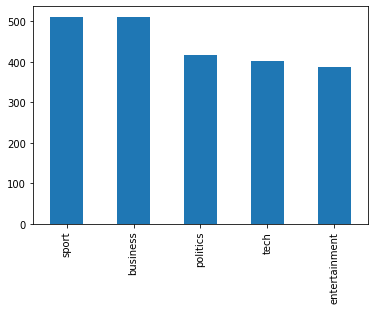

In [ ]:
# Checking number of records of each label
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,text,label
0,Asia is set to drive global media growth to ...,4
1,"Two-thirds of the world's population, 4 bill...",4
2,"Viruses, trojans and other malicious program...",4
3,A survey conducted by PC Pro Magazine has re...,4
4,Two men who were part of a huge network of i...,4


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df.head()

,text,label
0,asia set drive global media growth beyond chi...,4
1,twothirds worlds population billion people li...,4
2,viruses trojans malicious programs sent net ca...,4
3,survey conducted pc pro magazine revealed many...,4
4,two men part huge network internet software pi...,4


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

1335
445
445


In [ ]:
# tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), y_train))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings), y_val))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
history = model.fit(train_dataset.shuffle(100).batch(16), epochs=8, batch_size=16, validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/8
84/84 [==============================] - 89s 949ms/step - loss: 1.4212 - accuracy: 0.5276 - val_loss: 0.5055 - val_accuracy: 0.9663
Epoch 2/8
84/84 [==============================] - 81s 967ms/step - loss: 0.4005 - accuracy: 0.9711 - val_loss: 0.2054 - val_accuracy: 0.9663
Epoch 3/8
84/84 [==============================] - 83s 986ms/step - loss: 0.1717 - accuracy: 0.9760 - val_loss: 0.1146 - val_accuracy: 0.9820
Epoch 4/8
84/84 [==============================] - 83s 987ms/step - loss: 0.0877 - accuracy: 0.9918 - val_loss: 0.0889 - val_accuracy: 0.9843
Epoch 5/8
84/84 [==============================] - 83s 988ms/step - loss: 0.0490 - accuracy: 0.9965 - val_loss: 0.0677 - val_accuracy: 0.9843
Epoch 6/8
84/84 [==============================] - 83s 989ms/step - loss: 0.0343 - accuracy: 0.9990 - val_loss: 0.0757 - val_accuracy: 0.9820
Epoch 7/8
84/84 [==============================] - 83s 988ms/step - loss: 0.0267 - accuracy: 0.9989 - val_loss: 0.0626 - val_accuracy: 0.9865
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


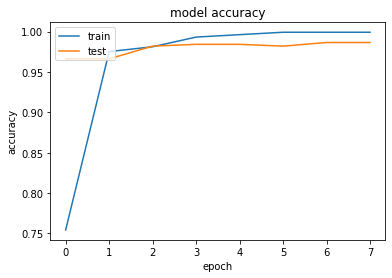

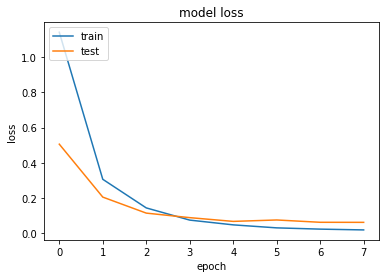

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_pretrained("distilbert_model")
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert_model")

Some layers from the model checkpoint at distilbert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

test_sentence = X_test[2]

predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = loaded_model.predict(predict_input)[0]
print(test_sentence)
print(tf_output)

gordon brown seek put economy centre labours bid third term power delivers ninth budget  gmt expected stress importance continued economic stability low unemployment interest rates chancellor expected freeze petrol duty raise stamp duty threshold   conservatives lib dems insist voters face higher taxes meanstesting labour treasury officials said preelection giveaway mr brown thought bn spare increase stamp duty threshold   freeze petrol duty extension tax credit scheme poorer families possible help pensioners stamp duty threshold rise intended help first time buyers likely theme three main parties general election manifestos ten years ago buyers much greater chance avoiding stamp duty close half million properties england wales alone selling less   since average uk property prices doubled starting threshold stamp duty increased tax credits result number properties incurring stamp duty rocketed governments tax take liberal democrats unveiled proposals raise stamp duty threshold   februa

In [ ]:
tf_prediction = tf.nn.softmax(tf_output, axis=1).numpy()[0]
print(tf_prediction)
print(tf_prediction.argmax())
print(le.inverse_transform([tf_prediction.argmax()]))

[0.0050681  0.00210258 0.9879215  0.00302084 0.00188714]
2
['politics']
